### baseline model only choose 1 as his strategy

100%|██████████| 1000/1000 [01:09<00:00, 14.38it/s]


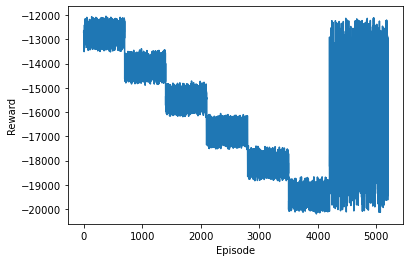

In [5]:
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt

class Car:
    def __init__(self, tyre="Intermediate"):
        self.default_tyre = tyre
        self.possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
        self.pitstop_time = 23
        self.reset()
    
    
    def reset(self):
        self.change_tyre(self.default_tyre)
    
    
    def degrade(self, w, r):
        if self.tyre == "Ultrasoft":
            self.condition *= (1 - 0.0050*w - (2500-r)/90000)
        elif self.tyre == "Soft":
            self.condition *= (1 - 0.0051*w - (2500-r)/93000)
        elif self.tyre == "Intermediate":
            self.condition *= (1 - 0.0052*abs(0.5-w) - (2500-r)/95000)
        elif self.tyre == "Fullwet":
            self.condition *= (1 - 0.0053*(1-w) - (2500-r)/97000)
        
        
    def change_tyre(self, new_tyre):
        assert new_tyre in self.possible_tyres
        self.tyre = new_tyre
        self.condition = 1.00
    
    
    def get_velocity(self):
        if self.tyre == "Ultrasoft":
            vel = 80.7*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Soft":
            vel = 80.1*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Intermediate":
            vel = 79.5*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Fullwet":
            vel = 79.0*(0.2 + 0.8*self.condition**1.5)
        return vel

    
class Track:
    def __init__(self, car=Car()):
        # self.radius and self.cur_weather are defined in self.reset()
        self.total_laps = 162
        self.car = car
        self.possible_weather = ["Dry", "20% Wet", "40% Wet", "60% Wet", "80% Wet", "100% Wet"]
        self.wetness = {
            "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
        }
        self.p_transition = {
            "Dry": {
                "Dry": 0.987, "20% Wet": 0.013, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "20% Wet": {
                "Dry": 0.012, "20% Wet": 0.975, "40% Wet": 0.013, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "40% Wet": {
                "Dry": 0.000, "20% Wet": 0.012, "40% Wet": 0.975, "60% Wet": 0.013, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "60% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.012, "60% Wet": 0.975, "80% Wet": 0.013, "100% Wet": 0.000
            },
            "80% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.012, "80% Wet": 0.975, "100% Wet": 0.013
            },
            "100% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.012, "100% Wet": 0.988
            }
        }
        self.reset()
    
    
    def reset(self):
        self.radius = np.random.randint(600,1201)
        self.cur_weather = np.random.choice(self.possible_weather)
        self.is_done = False
        self.pitstop = False
        self.laps_cleared = 0
        self.car.reset()
        return self._get_state()
    
    
    def _get_state(self):
        return [self.car.tyre, self.car.condition, self.cur_weather, self.radius, self.laps_cleared]
        
    
    def transition(self, action=0):
        """
        Args:
            action (int):
                0. Make a pitstop and fit new ‘Ultrasoft’ tyres
                1. Make a pitstop and fit new ‘Soft’ tyres
                2. Make a pitstop and fit new ‘Intermediate’ tyres
                3. Make a pitstop and fit new ‘Fullwet’ tyres
                4. Continue the next lap without changing tyres
        """
        ## Pitstop time will be added on the first eight of the subsequent lap
        time_taken = 0
        if self.laps_cleared == int(self.laps_cleared):
            if self.pitstop:
                self.car.change_tyre(self.committed_tyre)
                time_taken += self.car.pitstop_time
                self.pitstop = False
        
        ## The environment is coded such that only an action taken at the start of the three-quarters mark of each lap matters
        if self.laps_cleared - int(self.laps_cleared) == 0.75:
            if action < 4:
                self.pitstop = True
                self.committed_tyre = self.car.possible_tyres[action]
            else:
                self.pitstop = False
        
        self.cur_weather = np.random.choice(
            self.possible_weather, p=list(self.p_transition[self.cur_weather].values())
        )
        # we assume that degration happens only after a car has travelled the one-eighth lap
        velocity = self.car.get_velocity()
        time_taken += (2*np.pi*self.radius/8) / velocity
        reward = 0 - time_taken
        self.car.degrade(
            w=self.wetness[self.cur_weather], r=self.radius
        )
        self.laps_cleared += 0.125
        
        if self.laps_cleared == self.total_laps:
            self.is_done = True
        
        next_state = self._get_state()
        return reward, next_state, self.is_done, velocity

class Agent:
    def act(self, state):
        return 1  # Always choose action 1


# Simulation with Agent that always selects action 1
new_car = Car()
env = Track(new_car)

agent = Agent()

rewards = []
radius_bins = [(600 + i*100, 600 + (i+1)*100) for i in range(6)]

for bin_idx, (start_radius, end_radius) in enumerate(radius_bins):
    for episode in tqdm(range(700)):
        state = env.reset()
        env.radius = np.random.randint(start_radius, end_radius)
        done = False
        G = 0
        while not done:
            action = agent.act(state)
            reward, next_state, done, _ = env.transition(action)
            state = deepcopy(next_state)
            G += reward
        rewards.append(G)

# Last 1000 episodes with random radii
for episode in tqdm(range(1000)):
    state = env.reset()  # Reset with random radius
    done = False
    G = 0
    while not done:
        action = agent.act(state)
        reward, next_state, done, _ = env.transition(action)
        state = deepcopy(next_state)
        G += reward
    rewards.append(G)

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()
